# Generative Adversarial Network

Trong bản notebook này em sẽ xây dựng lại một generative adversarial network (GAN) trên bộ dữ liệu MNIST và dữ liệu khuôn mặt Toronto (TFD) và CIFAR-10.
Từ đó chúng ta có thể sinh dữ liệu mới . Notebook này được tham khảo bài MNIST_GAN


Ý tưởng đằng sau GAN là 2 mạng lưới đối nghịch, 1 mạng sinh dữ liệu giả generator $G$ và 1 mạng phân lớp discriminator $D$. The generator cần phải làm giả dữ liệu để qua mặt được bộ phân lớp D. The discriminator xem được dữ liệu huấn luyện thực và phần biệt nó là thật hay giả.
> * Bộ sinh (G) được huấn luyện để đánh lừa bộ phân biệt, nó muốn sinh ra dữ liệu giống với dữ liệu huấn luyện thật nhất có thể. 
> * Bộ phân biệt (D) là một bộ phân loại được đào tạo để tìm ra dữ liệu nào là thật và dữ liệu nào là giả mạo. 

Bộ sinh (G) học cách tạo dữ liệu không thể phân biệt được với dữ liệu thực cho bộ phân biệt (D).

<!-- <img src='https://github.com/udacity/deep-learning-v2-pytorch/raw/661c38e1c6a1f6734c26ecd899b958533c41cf1f/gan-mnist/assets/gan_pipeline.png' width=70% /> -->


# Import thư viện

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms


# Input dữ liệu

In [2]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training Fashion MNIST datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Visualize dữ liệu

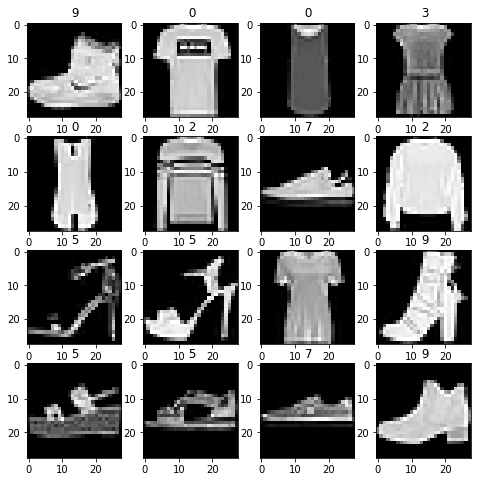

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()



# Trực quan hoá dữ liệu
def draw_samples(imgs,labels):
  plt.subplots(4, 4, figsize=(8,8))
  # số lượng sample trên hàng và cột
  columns = 4
  rows = 4
  for i in range(1, columns*rows+1):
      img = np.squeeze(imgs[i-1])
      plt.subplot(rows, columns, i)
      plt.title((f' {labels[i-1]}'))

      plt.imshow(img,  cmap='gray')
  plt.show()  


draw_samples(images,labels)




---
# Xây dựng mô hình

GAN gồm 2 mạng đối nghịch , bộ phân biệt(D) và bộ sinh(G)


## Discriminator
Xây dựng bộ phân biệt (D) là một mạng MLP điển hình. Mạng đầu ra với 2 lớp là 0 (fake data) và 1 (realdata).
Mạng sử dụng hàm kích hoạt activation leaky_relu. Sử dụng dropout để chống over-fitting. Hàm sigmoid để phân biệt về các lớp đầu ra là 0,1.



In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

## Generator
Mạng sinh(G) sẽ giống với mạng phân biệt nhưng sẽ đi ngược lại chiều của mạng phân biệt. Ở mạng phân biệt(D) đầu ra là 2 lớp nhưng với mạng sinh (G) đầu vào của nó lại là các noize (z) với d chiều (tuỳ chỉnh).

#### tanh Output
Bộ sinh đã được phát hiện là hoạt động tốt nhất hàm kích hoạt $ tanh $ cho đầu ra của bộ sinh (-1,1)



In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

## Siêu tham số của mô hình

In [6]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32


# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

## Xây dựng mạng hoàn chỉnh


In [7]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


---
## Discriminator and Generator Losses ( Xây dựng hàm mất mát cho D và G )

Tính toán hàm mất mát (losses)

### Discriminator Losses

> * Đối với bộ phân biệt, loss bằng tổng loss trên dữ liệu thật $x$ và dữ liệu sinh ra từ $G(z)$, `d_loss = d_real_loss + d_fake_loss `


Sử dụng hàm kích hoạt sigmoid và hàm mất mát cross entropy loss để phân lớp MLP.

Đối với hình ảnh thực, chúng ta muốn D `D(real_images) = 1`. Để giúp bộ phân biệt tổng quát tốt hơn, các nhãn được giảm một chút từ 1,0 xuống 0,9. Sử dụng tham số `smooth`; nếu True, thì chúng ta nên làm mịn nhãn. Trong PyTorch, nó giống như `labels = torch.ones(size) * 0.9`

Loss của dữ liệu giả cũng tương tự, chúng ta muốn `D(fake_images) = 0` trong đó `fake_images = G(z)`. 

### Generator Loss

Mục tiêu của bộ sinh là `D(fake_images) = 1`. 

In [8]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers 

Sử dụng hàm tối ưu hoá Adam cho cả 2 mạng

In [9]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training ( Huấn luyên)

Huấn luyện sẽ xen kẽ giữa huấn luyện bộ phân biệt và bộ sinh.

### Discriminator training ( Huấn luyện bộ phân biệt )
1. Tính toán discriminator loss trên dữ liệu thật thật, dữ liệu huấn luyện.     
2. Sinh dữ liệu giả
3. Tính toán discriminator loss trên dữ liệu giả được G sinh ra 
4. Cập nhật realloss và fakeloss
5. Lan truyền ngược sai số để cập nhật trọng số cho bộ phân biệt D

### Generator training ( Huấn luyện bộ sinh )
1. Sinh dữ liệu giả
2. Tính toán discriminator loss trên dữ liệu giả, dùng nhãn **flipped** !
3. Lan truyền ngược sai số để cập nhật trọng số cho bộ sinh G

#### Saving Samples (Lưu samples)

Trong quá trình huấn luyện, in ra loss statistics và lưu một số dữ liệu giả được sinh ra bởi G.

In [10]:
import pickle as pkl
# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 800

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):

  for batch_i, (real_images, _) in enumerate(train_loader):

      batch_size = real_images.size(0)

      ## Important rescaling step ## 
      real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)

      # ============================================
      #            TRAIN THE DISCRIMINATOR
      # ============================================

      d_optimizer.zero_grad()

      # 1. Train with real images

      # Compute the discriminator losses on real images 
      # smooth the real labels
      D_real = D(real_images)
      d_real_loss = real_loss(D_real, smooth=True)

      # 2. Train with fake images

      # Generate fake images
      # gradients don't have to flow during this step
      with torch.no_grad():
          z = np.random.uniform(-1, 1, size=(batch_size, z_size))
          z = torch.from_numpy(z).float()
          fake_images = G(z)

      # Compute the discriminator losses on fake images        
      D_fake = D(fake_images)
      d_fake_loss = fake_loss(D_fake)

      # add up loss and perform backprop
      d_loss = d_real_loss + d_fake_loss
      d_loss.backward()
      d_optimizer.step()


      # =========================================
      #            TRAIN THE GENERATOR
      # =========================================
      g_optimizer.zero_grad()

      # 1. Train with fake images and flipped labels

      # Generate fake images
      z = np.random.uniform(-1, 1, size=(batch_size, z_size))
      z = torch.from_numpy(z).float()
      fake_images = G(z)

      # Compute the discriminator losses on fake images 
      # using flipped labels!
      D_fake = D(fake_images)
      g_loss = real_loss(D_fake) # use real loss to flip labels

      # perform backprop
      g_loss.backward()
      g_optimizer.step()

      # Print some loss stats
      if batch_i % print_every == 0:
        if epoch % 4 ==0:
          # print discriminator and generator loss
          print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                  epoch+1, num_epochs, d_loss.item(), g_loss.item()))


  ## AFTER EACH EPOCH##
  # append discriminator loss and generator loss
  losses.append((d_loss.item(), g_loss.item()))

  # generate and save sample, fake images
  G.eval() # eval mode for generating samples
  samples_z = G(fixed_z)
  samples.append(samples_z)
  G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
  pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.4007 | g_loss: 0.6504
Epoch [    1/  100] | d_loss: 0.8754 | g_loss: 2.4839
Epoch [    5/  100] | d_loss: 1.1125 | g_loss: 1.7120
Epoch [    5/  100] | d_loss: 1.0224 | g_loss: 1.8334
Epoch [    9/  100] | d_loss: 1.2046 | g_loss: 1.3763
Epoch [    9/  100] | d_loss: 1.2400 | g_loss: 0.9461
Epoch [   13/  100] | d_loss: 1.2495 | g_loss: 1.1388
Epoch [   13/  100] | d_loss: 1.1512 | g_loss: 1.7621
Epoch [   17/  100] | d_loss: 1.0308 | g_loss: 1.9325
Epoch [   17/  100] | d_loss: 1.1861 | g_loss: 1.2376
Epoch [   21/  100] | d_loss: 1.2084 | g_loss: 1.2767
Epoch [   21/  100] | d_loss: 1.2349 | g_loss: 1.2728
Epoch [   25/  100] | d_loss: 1.1409 | g_loss: 1.7894
Epoch [   25/  100] | d_loss: 1.2783 | g_loss: 0.9168
Epoch [   29/  100] | d_loss: 1.3111 | g_loss: 0.9870
Epoch [   29/  100] | d_loss: 1.2074 | g_loss: 1.2268
Epoch [   33/  100] | d_loss: 1.1412 | g_loss: 1.1772
Epoch [   33/  100] | d_loss: 1.3055 | g_loss: 1.2566
Epoch [   37/  100] | d_loss

## Training loss
Biểu đồ training losses cho G và D, lưu lại sau mỗi epoch train.

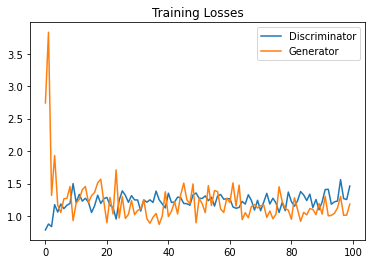

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training (Tạo samples từ quá trình huấn luyện)


Xem 1 số hình ảnh từ bộ sinh generator trong quá trình đào tạo

In [12]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [13]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

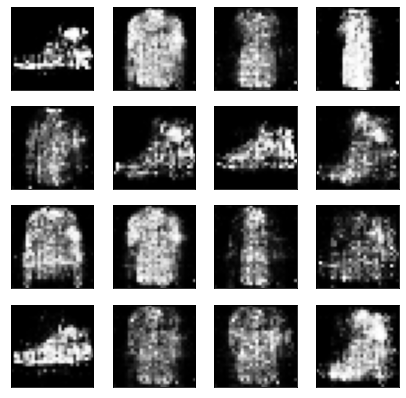

In [14]:
# -1 indicates final epoch's samples (the last in the list)


view_samples(-1, samples)

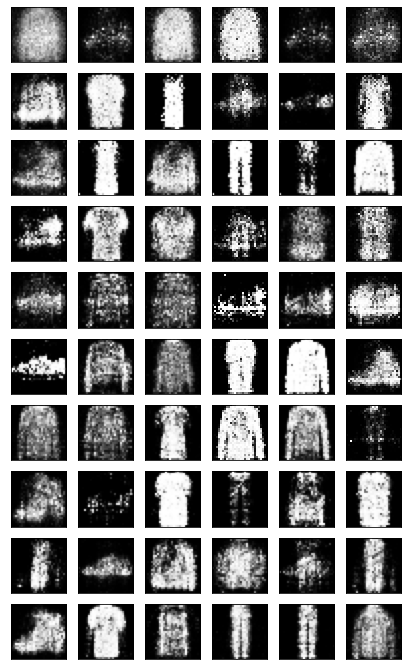

In [15]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


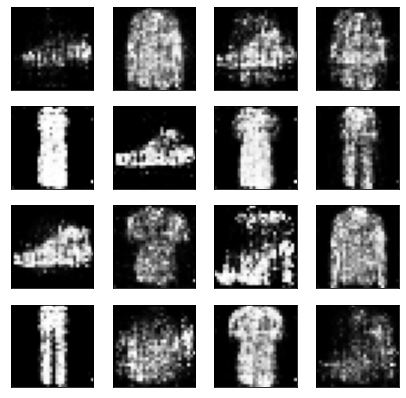

In [16]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])